In [1]:
!which pip

/data/serrano/miniconda3/wisp/bin/pip


In [2]:
import airfrans as af
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATASET = "/data/serrano/airfrans/Dataset/"

In [4]:
import numpy as np

In [5]:
import torch

In [6]:
MIN_POS = torch.Tensor([-2.25, -1.65]).view(-1, 2)
MAX_POS = torch.Tensor([4.25, 1.65]).view(-1,2)

In [7]:
key_to_index = {
    "x": 0,
    "y": 1,
    "inlet_x": 2,
    "inlet_y": 3,
    "sdf": 4,
    "nx": 5,
    "ny": 6,
    "vx": 7,
    "vy": 8,
    "p": 9,
    "nu":10,
}

In [8]:
from __future__ import annotations
from typing import Dict, Any
import logging as log
import torch
import torch.nn as nn
import torch.nn.functional as F
import kaolin.ops.spc as spc_ops
import wisp.ops.spc as wisp_spc_ops
from wisp.models.grids.octree_grid import OctreeGrid
from wisp.accelstructs import OctreeAS

In [9]:
from wisp.models.grids.codebook_grid import CodebookOctreeGrid

In [10]:
class ModulatedCodebookOctreeGrid(CodebookOctreeGrid):
    """This is a multiresolution feature grid where the octree stores indices into a fixed size codebook.
    """
    def __init__(
        self,
        accelstruct,
        feature_dim         : int,
        base_lod            : int,
        num_lods            : int          = 1,
        interpolation_type  : str          = 'linear',
        multiscale_type     : str          = 'cat',
        feature_std         : float        = 0.0,
        feature_bias        : float        = 0.0,
        codebook_bitwidth   : int          = 8
    ):
        """
        Args:
            accelstruct: Spatial acceleration structure which tracks the occupancy state of this grid.
                         Used to speed up spatial queries and ray tracing operations.
            feature_dim (int): The dimension of the features stored on the grid.
            base_lod (int): The base LOD of the feature grid.
                            This is the lowest LOD of the  octree for which features are defined.
            num_lods (int): The number of LODs for which features are defined. Starts at base_lod.
                            i.e. base_lod=4 and num_lods=5 means features are kept for levels 5, 6, 7, 8.
            interpolation_type (str): The type of interpolation function used when querying features on the grid.
                                      'linear' - uses trilinear interpolation from nearest 8 nodes.
                                      'closest' - uses feature from nearest grid node.
            multiscale_type (str): The type of multiscale aggregation.
                                   'sum' - aggregates features from different LODs with summation.
                                   'cat' - aggregates features from different LODs with concatenation.
                                   Note that 'cat' will change the decoder input dimension to num_lods * feature_dim.
            feature_std (float): The features are initialized with a Gaussian distribution with the given
                                 standard deviation.
            feature_bias (float): The features are initialized with a Gaussian distribution with the given mean.
            codebook_bitwidth (int): Codebook dictionary_size is set as 2**bitwidth
        """
        self.bitwidth = codebook_bitwidth
        super().__init__(accelstruct=accelstruct,
                         feature_dim=feature_dim,
                         base_lod=base_lod,
                         num_lods=num_lods,
                         interpolation_type=interpolation_type,
                         multiscale_type=multiscale_type,
                         feature_std=feature_std,
                         feature_bias=feature_bias)
        
    def _index_features(self, feats, extra_dic, idx, lod_idx):
        """Internal function. Returns the feats based on indices.
        Args:
            feats (torch.FloatTensor): tensor of feats of shape [num_feats, feat_dim]
            idx (torch.LongTensor): indices of shape [num_indices]
            lod_idx (int): index to `self.active_lods`.
        Returns:
            (torch.FloatTensor): tensor of feats of shape [num_indices, feat_dim]
        """
        # idx -> [N, 8]
        # [1, 1, 256, 32] * [N, 8, 256, 1] -> [N, 8, 32]
        
        if self.training:
            logits = feats[idx.long()]
            y_soft = F.softmax(logits, dim=-1)
            index = y_soft.max(-1, keepdim=True)[1]
            y_hard = torch.zeros_like(
                logits, memory_format=torch.legacy_contiguous_format
            ).scatter_(-1, index, 1.0)
            keys = y_hard - y_soft.detach() + y_soft
            tmp_dic = self.dictionary + extra_dic[lod_idx]
            return (tmp_dic[None, None] * keys[..., None]).sum(-2)
            
            # TODO(ttakikawa): Replace with a cleaner / faster softmax implementation
            #keys = F.softmax(feats[idx.long()], dim=-1)
            #return softmax_dictionary(keys, self.dictionary[lod_idx])
        else:
            # [N, 8, 256] -> [N, 8]
            #keys = feats[idx.long()].long()
            keys = torch.max(feats[idx.long()], dim=-1)[1]
            return self.dictionary[lod_idx][keys] + extra_dic[lod_idx][keys]
    
    def _interpolate(self, coords, feats, extra_dic, pidx, lod_idx):
        """Query multiscale features.
        Args:
            coords (torch.FloatTensor): coords of shape [batch, num_samples, 3]
            lod_idx  (int): int specifying the index to ``active_lods`` 
            pidx (torch.LongTensor): point_hiearchy indices of shape [batch]
            features (torch.FloatTensor): features to interpolate. If ``None``, will use `self.features`.
        Returns:
            (torch.FloatTensor): interpolated features of shape [batch, num_samples, feature_dim]
        """
        batch, num_samples = coords.shape[:2]

        if self.interpolation_type == 'linear':
            
            fs = torch.zeros(batch, num_samples, self.feature_dim, device=coords.device)
            
            valid_mask = pidx > -1
            valid_pidx = pidx[valid_mask]
            if valid_pidx.shape[0] == 0:
                return fs

            corner_feats = self._index_features(feats, extra_dic, self.trinkets.index_select(0, valid_pidx).long(), lod_idx)[:, None]
            
            pts = self.blas.points.index_select(0, valid_pidx)[:,None].repeat(1, coords.shape[1], 1)

            coeffs = spc_ops.coords_to_trilinear_coeffs(coords[valid_mask], pts, self.active_lods[lod_idx])[..., None]
            fs[valid_mask] = (corner_feats * coeffs).sum(-2)

        elif self.interpolation_type == 'closest':
            raise NotImplementedError
        else:
            raise Exception(f"Interpolation mode {self.interpolation_type} is not supported.")
        
        return fs
    
    def interpolate(self, coords, extra_dic, lod_idx):
        """Query multiscale features.
        Args:
            coords (torch.FloatTensor): coords of shape [batch, num_samples, 3] or [batch, 3]
            lod_idx  (int): int specifying the index to ``active_lods``
            features (torch.FloatTensor): features to interpolate. If ``None``, will use `self.features`.
        Returns:
            (torch.FloatTensor): interpolated features of shape
            [batch, num_samples, feature_dim] or [batch, feature_dim]
        """
        # Remember desired output shape, and inflate to (batch, num_samples, 3) format
        output_shape = coords.shape[:-1]
        if coords.ndim < 3:
            coords = coords[:, None]    # (batch, 3) -> (batch, num_samples, 3)

        if lod_idx == 0:
            query_results = self.blas.query(coords[:,0], self.active_lods[lod_idx], with_parents=False)
            pidx = query_results.pidx
            feat = self._interpolate(coords, extra_dic, self.features[0], pidx, 0)
            return feat.reshape(*output_shape, feat.shape[-1])
        else:
            feats = []
            
            # In the multiscale case, the raytrace _currently_  does not return multiscale indices.
            # As such, no matter what the pidx will be recalculated to get the multiscale indices.
            num_feats = lod_idx + 1
            
            # This might look unoptimal since it assumes that samples are _not_ in the same voxel.
            # This is the correct assumption here, because the point samples are from the base_lod,
            # not the highest LOD.
            query_results = self.blas.query(coords.reshape(-1, 3), self.active_lods[lod_idx], with_parents=True)
            pidx = query_results.pidx[...,self.base_lod:]
            pidx = pidx.reshape(-1, coords.shape[1], num_feats)
            pidx = torch.split(pidx, 1, dim=-1)
            
            # list of [batch, num_samples, 1]

            for i in range(num_feats):
                feat = self._interpolate(
                    coords.reshape(-1, 1, 3), extra_dic, self.features[i], pidx[i].reshape(-1), i)[:,0]
                feats.append(feat)
            
            feats = torch.cat(feats, dim=-1)

            if self.multiscale_type == 'sum':
                feats = feats.reshape(*feats.shape[:-1], num_feats, self.feature_dim)
                if self.training:
                    feats = feats.sum(-2)
                else:
                    feats = feats.sum(-2)
            
            return feats.reshape(*output_shape, self.feature_dim)

# 2. Try to fit a single image for each channel

In [11]:
import os
import sys
from pathlib import Path
sys.path.append("/home/serrano/Projects/INR_domain_decomposition/")

from src.data.dataset import GeometryDataset, KEY_TO_INDEX
from torch_geometric.loader import DataLoader

import einops
import json
import numpy as np
import torch
import torch.nn as nn
from graph_metalearning import outer_step

In [12]:
import yaml
from omegaconf import DictConfig

In [13]:
with open('../config/basic.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
cfg = DictConfig(cfg)

In [14]:
data_dir = cfg.data.dir
task = cfg.data.task
data_to_encode = cfg.data.data_to_encode
score = cfg.data.score
ntrain = cfg.data.ntrain
ntest = cfg.data.ntest
seed = cfg.data.seed

# optim
batch_size = cfg.optim.batch_size
batch_size_val = (
    batch_size if cfg.optim.batch_size_val == None else cfg.optim.batch_size_val
)
lr_inr = cfg.optim.lr_inr
lr_code = cfg.optim.lr_code
meta_lr_code = cfg.optim.meta_lr_code
weight_decay_code = cfg.optim.weight_decay_code
inner_steps = cfg.optim.inner_steps
test_inner_steps = cfg.optim.test_inner_steps
epochs = cfg.optim.epochs
weight_decay = cfg.optim.weight_decay

# inr
model_type = cfg.inr.model_type
latent_dim = cfg.inr.latent_dim
depth = cfg.inr.depth
hidden_dim = cfg.inr.hidden_dim
w0 = cfg.inr.w0
use_latent = cfg.inr.use_latent
modulate_scale = cfg.inr.modulate_scale
modulate_shift = cfg.inr.modulate_shift
hypernet_depth = cfg.inr.hypernet_depth
hypernet_width = cfg.inr.hypernet_width
loss_type = cfg.inr.loss_type
gamma = cfg.inr.gamma

In [15]:
data_to_encode = 'vx'

In [16]:
data_dir = '/data/serrano/airfrans/'
print('data_dir', data_dir)

# train
with open(Path(data_dir) / 'Dataset/manifest.json', 'r') as f:
    manifest = json.load(f)

manifest_train = manifest[task + '_train']
testset = manifest[task + '_test'] if task != 'scarce' else manifest['full_test']
n = int(.9*len(manifest_train))

print("len manifest train", manifest_train, n)

trainset = manifest_train[:20] # was [:-n] ???
valset = manifest_train[-20:]

ntrain = len(trainset)
nval = len(valset)

data_dir /data/serrano/airfrans/
len manifest train ['airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16.283', 'airFoil2D_SST_58.831_-3.563_2.815_4.916_10.078', 'airFoil2D_SST_43.327_8.905_4.236_6.511_10.744', 'airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19.856', 'airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10.656', 'airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7.489', 'airFoil2D_SST_46.246_9.78_3.769_2.353_17.745', 'airFoil2D_SST_67.481_-1.259_5.136_2.438_18.882', 'airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12.285', 'airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17.471', 'airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14.763', 'airFoil2D_SST_46.0_-0.095_2.322_1.874_16.58', 'airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11.955', 'airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8.866', 'airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5.008', 'airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10.604', 'airFoil2D_SST_71.85_7.865_2.88_6.646_0.0_18.137', 'airFoil2D_SST_90.26_10.644_0.076_3.962_1.0_18.874', 'airFoil2D_SST

In [17]:
#default sample is none
trainset = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample='uniform', n_boot=16000)
print("loaded train")
valset = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample='uniform', n_boot=16000, coef_norm=trainset.coef_norm)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
# test
val_loader = DataLoader(valset, batch_size=batch_size_val, shuffle=True)
device = torch.device("cuda")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.05it/s]


coef_norm (array([ 5.00952303e-01,  1.13321105e-02,  6.05853500e+01,  4.67220497e+00,
        2.31252700e-01, -1.67829567e-03, -8.47164993e-05], dtype=float32), array([ 0.70306975,  0.33679357, 17.544584  ,  5.7692056 ,  0.47445256,
        0.04213712,  0.06204045], dtype=float32), array([ 4.1554970e+01,  8.7277184e+00, -2.4333244e+02,  7.6442689e-04],
      dtype=float32), array([2.8129255e+01, 2.6411243e+01, 1.8448706e+03, 2.5445439e-03],
      dtype=float32))
loaded train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  3.20it/s]

coef_norm (array([ 5.00952303e-01,  1.13321105e-02,  6.05853500e+01,  4.67220497e+00,
        2.31252700e-01, -1.67829567e-03, -8.47164993e-05], dtype=float32), array([ 0.70306975,  0.33679357, 17.544584  ,  5.7692056 ,  0.47445256,
        0.04213712,  0.06204045], dtype=float32), array([ 4.1554970e+01,  8.7277184e+00, -2.4333244e+02,  7.6442689e-04],
      dtype=float32), array([2.8129255e+01, 2.6411243e+01, 1.8448706e+03, 2.5445439e-03],
      dtype=float32))


In [18]:
import wisp

In [19]:
from wisp.accelstructs import OctreeAS
from wisp.models.decoders.basic_decoders import BasicDecoder
from wisp.models.grids import BLASGrid, OctreeGrid, CodebookOctreeGrid, TriplanarGrid, HashGrid
from wisp.tracers import BaseTracer, PackedSDFTracer
from wisp.models.nefs import BaseNeuralField, NeuralSDF
from wisp.models.pipeline import Pipeline
from wisp.trainers import BaseTrainer, SDFTrainer

In [20]:
# Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.
#
# NVIDIA CORPORATION & AFFILIATES and its licensors retain all intellectual property
# and proprietary rights in and to this software, related documentation
# and any modifications thereto.  Any use, reproduction, disclosure or
# distribution of this software and related documentation without an express
# license agreement from NVIDIA CORPORATION & AFFILIATES is strictly prohibited.

import torch
from typing import Dict, Any

from wisp.models.nefs import BaseNeuralField
from wisp.models.embedders import get_positional_embedder
from wisp.models.layers import get_layer_class
from wisp.models.activations import get_activation_class
from wisp.models.decoders import BasicDecoder
from wisp.models.grids import BLASGrid


class MyNeuralField(BaseNeuralField):
    """Model for encoding neural signed distance functions (implicit surfaces).
    This field implementation uses feature grids for faster and more efficient queries.
    For example, the usage of Octree follows the idea from Takikawa et al. 2021 (Neural Geometric Level of Detail).
    """
    def __init__(self,
                 grid: BLASGrid = None,
                 # embedder args
                 pos_embedder: str = 'none',
                 pos_multires: int = 10,
                 position_input: bool = True,
                 # decoder args
                 activation_type: str = 'relu',
                 layer_type: str = 'none',
                 hidden_dim: int = 128,
                 num_layers: int = 1
                 ):
        """
        Creates a new neural field of an implicit furface, which maps 3D input coordinates to SDF values.

        This neural field consists of:
         * A feature grid (backed by an acceleration structure to boost raymarching speed)
         * SDF decoder
         * Optional: positional embedders for input position coords, concatenated to grid features.

         This neural field also supports:
          * Aggregation of multi-resolution features (more than one LOD) via summation or concatenation

        Args:
            grid: (BLASGrid): represents feature grids in Wisp. BLAS: "Bottom Level Acceleration Structure",
                to signify this structure is the backbone that captures
                a neural field's contents, in terms of both features and occupancy for speeding up queries.
                Notable examples: OctreeGrid, HashGrid, TriplanarGrid.

            pos_embedder (str): Type of positional embedder to use for input coordinates.
                Options:
                 - 'none': No positional input is fed into the SDF decoder.
                 - 'identity': The sample coordinates are fed as is into the SDF decoder.
                 - 'positional': The sample coordinates are embedded with the Positional Encoding from
                    Mildenhall et al. 2020, before passing them into the SDF decoder.
            pos_multires (int): Number of frequencies used for 'positional' embedding of pos_embedder.
                 Used only if pos_embedder is 'positional'.
            position_input (bool): If True, the input coordinates will be passed into the decoder.
                 For 'positional': the input coordinates will be concatenated to the embedded coords.
                 For 'none' and 'identity': the embedder will behave like 'identity'.
            activation_type (str): Type of activation function to use in BasicDecoder:
                 'none', 'relu', 'sin', 'fullsort', 'minmax'.
            layer_type (str): Type of MLP layer to use in BasicDecoder:
                 'none' / 'linear', 'spectral_norm', 'frobenius_norm', 'l_1_norm', 'l_inf_norm'.
            hidden_dim (int): Number of neurons in hidden layers of SDF decoder.
            num_layers (int): Number of hidden layers in SDF decoder.
        """
        super().__init__()
        self.grid = grid

        # Init Embedders
        self.pos_multires = pos_multires
        self.position_input = position_input
        self.pos_embedder, self.pos_embed_dim = self.init_embedder(pos_embedder, pos_multires, position_input)

        # Init Decoder
        self.activation_type = activation_type
        self.layer_type = layer_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.decoder = self.init_decoder(activation_type, layer_type, num_layers, hidden_dim)

        torch.cuda.empty_cache()

    def init_embedder(self, embedder_type, frequencies=None, position_input=True):
        """Creates positional embedding functions for the position and view direction.
        """
        if embedder_type == 'none' and not position_input:
            embedder, embed_dim = None, 0
        elif embedder_type == 'identity' or (embedder_type == 'none' and position_input):
            embedder, embed_dim = torch.nn.Identity(), 3
        elif embedder_type == 'positional':
            embedder, embed_dim = get_positional_embedder(frequencies=frequencies, position_input=position_input)
        else:
            raise NotImplementedError(f'Unsupported embedder type for NeuralSDF: {embedder_type}')
            
        return embedder, embed_dim

    def init_decoder(self, activation_type, layer_type, num_layers, hidden_dim):
        """Initializes the decoder object.
        """
        decoder = BasicDecoder(input_dim=self.decoder_input_dim(),
                               output_dim=1,
                               activation=get_activation_class(activation_type),
                               bias=True,
                               layer=get_layer_class(layer_type),
                               num_layers=num_layers,
                               hidden_dim=hidden_dim,
                               skip=[])
        return decoder

    def register_forward_functions(self):
        """Register the forward functions.
        """
        self._register_forward_function(self.velocity, ["velocity"])

    def velocity(self, coords, lod_idx=None):
        """Computes the Signed Distance Function for input samples.

        Args:
            coords (torch.FloatTensor): tensor of shape [batch, num_samples, 3]
            lod_idx (int): index into active_lods. If None, will use the maximum LOD.
        
        Outputs:
            (torch.FloatTensor):
            - SDF of shape [batch, num_samples, 1]
        """
        shape = coords.shape
        
        if shape[0] == 0:
            return dict(sdf=torch.zeros_like(coords)[...,0:1])

        if lod_idx is None:
            lod_idx = self.grid.num_lods - 1

        if len(shape) == 2:
            coords = coords[:, None]
        num_samples = coords.shape[1]

        feats = self.grid.interpolate(coords, lod_idx)

        # Optionally concat the positions to the embedding
        if self.pos_embedder is not None:
            feats = torch.cat([self.pos_embedder(coords.view(-1, 2)).view(-1, num_samples, self.pos_embed_dim), 
                               feats], dim=-1)

        out = self.decoder(feats)

        if len(shape) == 2:
            out = out[:,0]
            
        return out

    def effective_feature_dim(self):
        if self.grid.multiscale_type == 'cat':
            effective_feature_dim = self.grid.feature_dim * self.grid.num_lods
        else:
            effective_feature_dim = self.grid.feature_dim
        return effective_feature_dim

    def decoder_input_dim(self):
        input_dim = self.effective_feature_dim()
        
        if self.position_input:
            input_dim += self.pos_embed_dim
        
        return input_dim

    def public_properties(self) -> Dict[str, Any]:
        """ Wisp modules expose their public properties in a dictionary.
        The purpose of this method is to give an easy table of outwards facing attributes,
        for the purpose of logging, gui apps, etc.
        """
        properties = {
            "Grid": self.grid,
            "Pos. Embedding": self.pos_embedder,
            "Decoder (sdf)": self.decoder,
        }
        return properties

In [21]:
def load_grid(args) -> BLASGrid:
    """Loads the hierarchical feature grid to use within the neural sdf pipeline.
    Grid choices are interesting to explore, so we leave the exact backbone type configurable,
    and show how grid instances may be explicitly constructed.
    Grids choices, for example, are: OctreeGrid, TriplanarGrid, HashGrid
    See corresponding grid constructors for each of their arg details.
    """
    
    grid = CodebookOctreeGrid.make_dense(
        feature_dim=args.feature_dim,
        base_lod=args.base_lod,
        num_lods=args.num_lods,
        interpolation_type=args.interpolation_type,
        multiscale_type=args.multiscale_type,
        feature_std=args.feature_std,
        feature_bias=args.feature_bias,
        codebook_bitwidth=args.codebook_bitwidth
    )

    return grid

In [22]:
def load_neural_field(args) -> BaseNeuralField:
    """ Creates a "Neural Field" instance which converts input coordinates to some output signal.
    Here a NeuralSDF is created, which maps 3D coordinates -> SDF values.
    NeuralSDF is a combo of a spatial feature grid and a single decoder.
    The NeuralSDF uses the grid internally for faster feature interpolation and raytracing.
    """
    grid = load_grid(args=args.grid)
    
    nef = ModulatedNeuralField(
        grid=grid,
        pos_embedder=wisp_cfg.nef.pos_embedder,
        pos_multires=wisp_cfg.nef.pos_multires,
        position_input=wisp_cfg.nef.position_input,
        activation_type=wisp_cfg.nef.activation_type,
        layer_type=wisp_cfg.nef.layer_type,
        hidden_dim=wisp_cfg.nef.hidden_dim,
        num_layers=wisp_cfg.nef.num_layers
    )
    return nef

In [23]:
with open('../config/wisp_codebook.yaml', 'r') as f:
    wisp_cfg = yaml.safe_load(f)
wisp_cfg = DictConfig(wisp_cfg)

In [24]:
wisp_cfg

{'data': {'dir': '/data/serrano/airfrans/', 'data_to_encode': 'vx', 'sample': 'mesh', 'task': 'full', 'score': 0, 'ntrain': None, 'ntest': None, 'seed': 123}, 'logging': {'exp_name': 'test-nglod-sdf'}, 'dataset': {'num_samples': 500000, 'samples_per_voxel': 32}, 'nef': {'hidden_dim': 64, 'num_layers': 2, 'pos_embedder': 'none', 'position_input': True, 'pos_multires': 4, 'layer_type': 'none', 'activation_type': 'relu'}, 'optimizer': {'optimizer_type': 'adam', 'eps': 1e-15, 'lr': 0.01, 'grid_lr_weight': 1.0, 'weight_decay': 0}, 'trainer': {'epochs': 10, 'batch_size': 512, 'model_format': 'full', 'valid_every': 10, 'save_every': 5, 'render_tb_every': 5, 'log_2d': True, 'only_last': True, 'resample': True}, 'tracer': {'num_steps': 32, 'step_size': 0.8}, 'renderer': {'render_batch': 0, 'camera_origin': [-2.8, 2.3, -2.8], 'shading_mode': 'matcap', 'render_res': [1024, 1024], 'shadow': True}, 'grid': {'grid_type': 'CodebookOctreeGrid', 'interpolation_type': 'linear', 'multiscale_type': 'sum',

In [25]:
grid = load_grid(wisp_cfg.grid)

In [93]:
nef.grid.dictionary_size

16

In [94]:
nef.grid.feature_dim

5

In [97]:
len(nef.grid.active_lods)

4

In [110]:
nef.grid.dictionary

ParameterList(
    (0): Parameter containing: [torch.float32 of size 16x5 (GPU 0)]
    (1): Parameter containing: [torch.float32 of size 16x5 (GPU 0)]
    (2): Parameter containing: [torch.float32 of size 16x5 (GPU 0)]
    (3): Parameter containing: [torch.float32 of size 16x5 (GPU 0)]
)

In [88]:
feats = nef.grid.interpolate(coords.cuda(), 0)

In [90]:
feats

tensor([[ 0.0002, -0.0007, -0.0062,  0.0101, -0.0099],
        [-0.0124,  0.0022, -0.0067, -0.0104,  0.0098],
        [ 0.0084,  0.0106,  0.0001, -0.0076,  0.0170],
        ...,
        [-0.0138,  0.0091,  0.0058, -0.0032, -0.0097],
        [ 0.0009, -0.0011,  0.0010,  0.0025, -0.0051],
        [-0.0093,  0.0050,  0.0103, -0.0092,  0.0026]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [107]:
fpyramid = []
for al in nef.grid.active_lods:
    if nef.grid.interpolation_type == 'linear':
        fpyramid.append(nef.grid.pyramid_dual[0,al]+1)
    elif self.interpolation_type == 'closest':
        fpyramid.append(nef.grid.blas.pyramid[0,al]+1)
    else:
        raise Exception(f"Interpolation mode {self.interpolation_type} is not supported.")
nef.grid.num_feat = sum(fpyramid).long()

In [108]:
fpyramid

[tensor(35938, dtype=torch.int32),
 tensor(274626, dtype=torch.int32),
 tensor(2146690, dtype=torch.int32),
 tensor(16974594, dtype=torch.int32)]

In [104]:
16*16*16

4096

In [111]:
nef.grid.pyramid_dual[0, 5]

tensor(35937, dtype=torch.int32)

In [27]:
def init_optimizer(nef, cfg):
    """Default initialization for the optimizer.
    """

    params_dict = { name : param for name, param in nef.named_parameters()}

    params = []
    decoder_params = []
    grid_params = []
    rest_params = []

    for name in params_dict:

        if 'decoder' in name:
            # If "decoder" is in the name, there's a good chance it is in fact a decoder,
            # so use weight_decay
            decoder_params.append(params_dict[name])

        elif 'grid' in name:
            # If "grid" is in the name, there's a good chance it is in fact a grid,
            # so use grid_lr_weight
            grid_params.append(params_dict[name])

        else:
            rest_params.append(params_dict[name])

    params.append({"params" : decoder_params,
                   "lr": cfg.lr, 
                   "weight_decay": cfg.weight_decay})

    params.append({"params" : grid_params,
                   "lr": cfg.lr * cfg.grid_lr_weight})

    params.append({"params" : rest_params,
                   "lr": cfg.lr})

    #optimizer = torch.optim.Adam(params, **cfg.optim_params)
    optimizer = torch.optim.Adam(params)
    
    return optimizer

In [130]:
optimizer = init_optimizer(nef, wisp_cfg.optimizer)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min', factor=0.5,
                                                       patience=500,
                                                       threshold=0.001,
                                                       threshold_mode='rel', cooldown=0, min_lr=1e-4, eps=1e-08, verbose=False)

In [115]:
output = nef.velocity(coords.cuda())

In [116]:
out = output.cpu().detach()

In [118]:
for graph, idx in train_loader:
    break

In [119]:
index = 0
mask = graph.batch == index

In [122]:
gamma = 5
coordinates = graph.pos[mask]
max_ = coordinates.max(0)[0]
min_ = coordinates.min(0)[0]

# rescale in -1, 1
coordinates = (coordinates - min_)/(max_ - min_) * 2 - 1

# stack z = 0
coordinates = torch.cat([coordinates, torch.zeros(coordinates.shape[0], 1)], axis=-1).cuda()

# scale images
images = graph.images[mask].cuda()
images_scaled = images/gamma 

In [132]:
epochs=10000
for step in range(epochs):
    pred = nef.velocity(coordinates)
    loss = ((pred - images_scaled)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if step % 100 == 0:
        print(f"loss: {((pred*gamma - images)**2).mean()}")

loss: 1.4318127632141113
loss: 0.5516442656517029
loss: 0.09505631774663925
loss: 0.027918612584471703
loss: 0.018008343875408173
loss: 0.01296602189540863
loss: 0.009334354661405087
loss: 0.0073002902790904045
loss: 0.007914126850664616
loss: 0.006024345755577087
loss: 0.004553969018161297
loss: 0.004146026913076639
loss: 0.0037467845249921083
loss: 0.0037381367292255163
loss: 0.0035580007825046778
loss: 0.003108747536316514
loss: 0.0026144839357584715
loss: 0.0025320646818727255
loss: 0.002800319343805313
loss: 0.00545145571231842
loss: 0.0021757998038083315
loss: 0.0022679294925183058
loss: 0.00211406615562737
loss: 0.0020617968402802944
loss: 0.0027421731501817703
loss: 0.0020617975387722254
loss: 0.001827749190852046
loss: 0.002134338952600956
loss: 0.001962244976311922
loss: 0.0016052557621151209
loss: 0.0016846234211698174
loss: 0.001671890844590962
loss: 0.0014924663119018078
loss: 0.0029715998098254204
loss: 0.0014721009647473693
loss: 0.0013543545501306653
loss: 0.00141268409

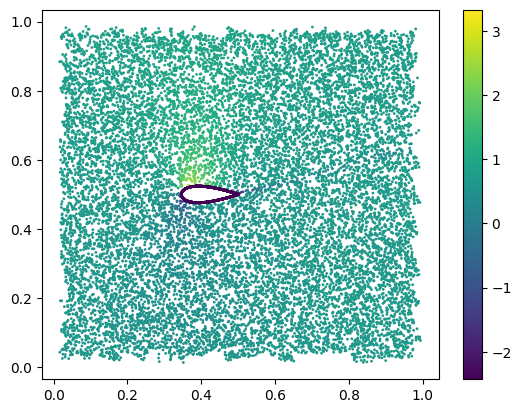

In [238]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=images.cpu().detach(), s=1)
plt.colorbar()

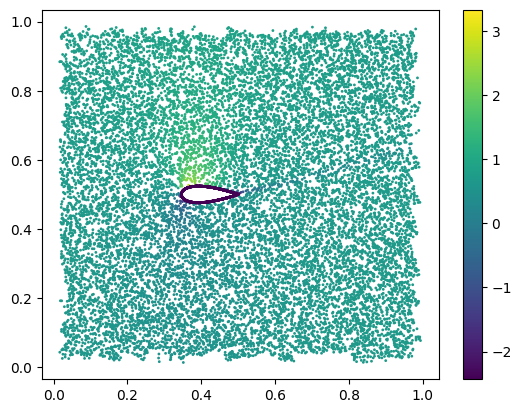

In [239]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=gamma*pred.cpu().detach(), s=1)
plt.colorbar()

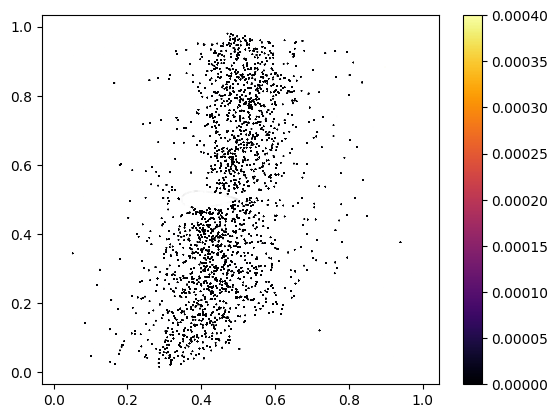

In [240]:
diff = ((gamma*pred - images)**2).cpu().detach()
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), s=diff, c=diff, cmap='inferno')
plt.colorbar()

In [241]:
diff.mean()

tensor(2.6157e-07)

In [174]:
mean_in, mean_out, std_in, std_out = trainset.coef_norm

In [175]:
std_in

array([ 6.1513180e+01,  4.6149511e+00, -1.0535362e+01,  1.5641948e-04],
      dtype=float32)

In [176]:
index_trained = idx[0]

In [182]:
graph_hr = dataset_list[index_trained]

In [183]:
pos_hr = torch.Tensor(graph_hr[..., :2])
pos_hr = (pos_hr - MIN_POS) / (MAX_POS - MIN_POS)

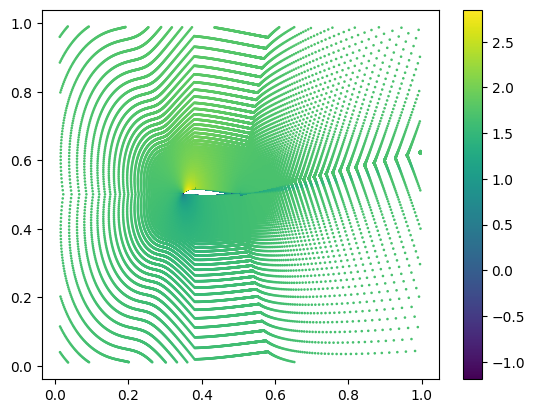

In [184]:
v_hr = (graph_hr[..., key_to_index['vx']] -mean_out[0] )/std_out[0]
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= v_hr)
plt.colorbar()

In [185]:
pred_hr = inr(torch.Tensor(pos_hr).cuda()).cpu().detach()*gamma

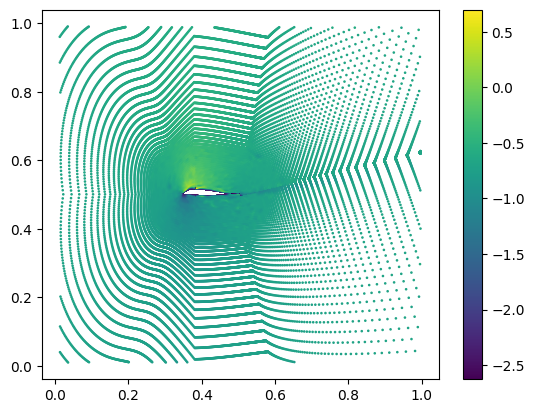

In [186]:
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= pred_hr)
plt.colorbar()

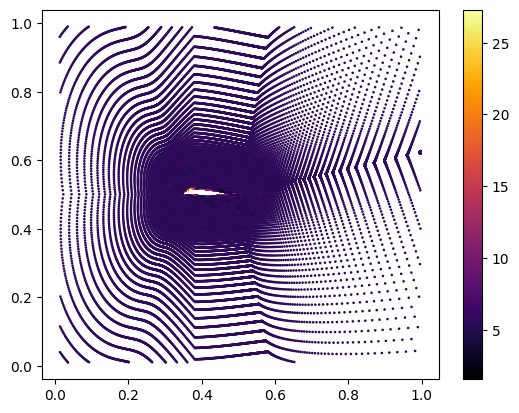

In [188]:
diff = ((pred_hr.detach().cpu().squeeze() - v_hr)**2)
plt.scatter(pos_hr[..., 0], pos_hr[..., 1], s=0.75, c= diff, cmap="inferno")
plt.colorbar()

# 3. With mesh sampling

In [27]:
trainset = manifest_train[:n] # was [:-n] ???
valset = manifest_train[n:]

In [28]:
#default sample is none
trainset2 = GeometryDataset(trainset, key=data_to_encode, latent_dim=latent_dim, norm=True, sample=None, n_boot=16000)
print("loaded train")
valset2 = GeometryDataset(valset, key=data_to_encode, latent_dim=latent_dim, sample=None, n_boot=16000, coef_norm=trainset2.coef_norm)

train_loader2 = DataLoader(trainset2, batch_size=batch_size, shuffle=True)
# test
val_loader2 = DataLoader(valset2, batch_size=batch_size_val, shuffle=True)
device = torch.device("cuda")

100%|█████████████████████████████████████████████████████████████████████████████████████| 720/720 [03:32<00:00,  3.39it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))
loaded train


100%|███████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:24<00:00,  3.26it/s]


coef_norm (array([ 5.0067395e-01,  1.1246346e-02,  6.1503807e+01,  4.8500433e+00,
        2.3172970e-01, -1.6548282e-03, -8.6467640e-05], dtype=float32), array([ 0.7040369 ,  0.3364    , 17.780106  ,  6.284955  ,  0.4752076 ,
        0.04153645,  0.06240817], dtype=float32), array([ 4.2436943e+01,  9.6964874e+00, -4.5236975e+02,  7.9545029e-04],
      dtype=float32), array([2.9641506e+01, 3.0877468e+01, 2.9632727e+03, 2.9404047e-03],
      dtype=float32))


In [46]:
with open('config/wisp_hash.yaml', 'r') as f:
    wisp_cfg = yaml.safe_load(f)
wisp_cfg = DictConfig(wisp_cfg)

In [50]:
wisp_cfg.grid.blas_level=8
wisp_cfg.grid.multiscale_type="sum"
wisp_cfg.nef.pos_multires=4
wisp_cfg.nef.activation_type = "sin"
wisp_cfg.nef.layer_type = "none"
wisp_cfg.optimizer.weight_decay=0

In [61]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [60]:
nef = load_neural_field(wisp_cfg).cuda()

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [52]:
optimizer = init_optimizer(nef, wisp_cfg.optimizer)

In [53]:
for graph, idx in train_loader2:
    break

In [54]:
index = 0
mask = graph.batch == index

In [55]:
gamma = 10
coordinates = graph.pos[mask].cuda()
images = graph.images[mask].cuda()
images_scaled = images/gamma # images/ gamma

In [58]:
optimizer.zero_grad()

In [59]:
epochs=10000
for step in range(epochs):
    pred = nef.velocity(coordinates)
    loss = ((pred - images_scaled)**2).mean()
    optimizer.zero_grad()
    with torch.cuda.nvtx.range("SDFTrainer.backward"):
        loss.backward()
        optimizer.step()

    if step % 100 == 0:
        print(f"loss: {((pred*gamma - images)**2).mean()}")

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasLtMatmul( ltHandle, computeDesc.descriptor(), &alpha_val, mat1_ptr, Adesc.descriptor(), mat2_ptr, Bdesc.descriptor(), &beta_val, result_ptr, Cdesc.descriptor(), result_ptr, Cdesc.descriptor(), &heuristicResult.algo, workspace.data_ptr(), workspaceSize, at::cuda::getCurrentCUDAStream())`

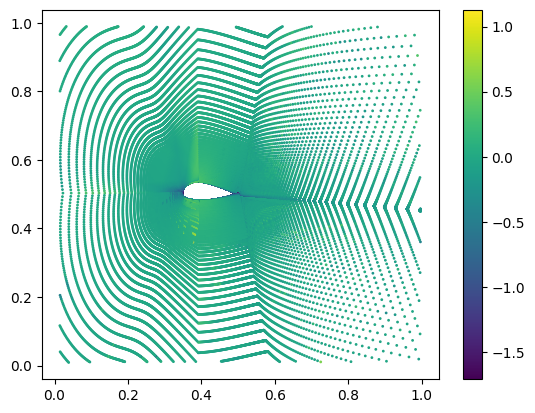

In [44]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

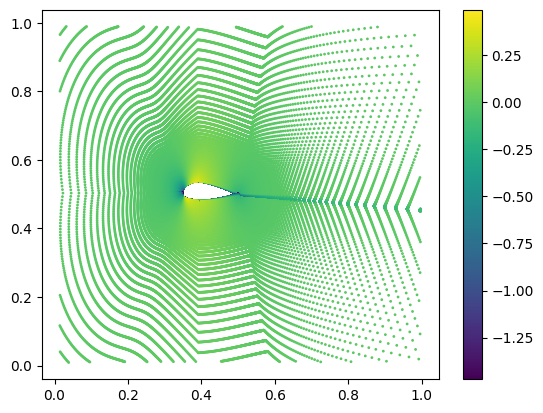

In [37]:
plt.scatter(coordinates[..., 0].detach().cpu(), coordinates[..., 1].detach().cpu(), c=images.detach().cpu(), s=1)
plt.colorbar()

In [321]:
w0 = 30
inr = Siren(dim_in=2,
            dim_hidden=256,
            dim_out=1,
            num_layers=5,
            w0=w0,
            w0_initial=w0,
            use_bias=True,
        ).cuda()

In [322]:
optimizer = torch.optim.Adam(inr.parameters(), lr=1e-4)

In [323]:
x_mask = (coordinates[..., 0] < 0.6) & (coordinates[..., 0] > 0.4)
y_mask = (coordinates[..., 1] < 0.6) & (coordinates[..., 1] > 0.4)
mask = x_mask & y_mask

In [324]:
coords_sub = (coordinates[mask] - 0.4)*100
images_sub = images_scaled[mask]

In [325]:
epochs=10000
for step in range(epochs):
    pred = inr(coords_sub)
    loss = ((pred - images_sub)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 200 == 0:
        print(f"loss: {((gamma*(pred - images_sub))**2).mean()}")

loss: 1.034475564956665
loss: 0.013061603531241417
loss: 0.007928073406219482
loss: 0.004260915331542492
loss: 0.0032179937697947025
loss: 0.0033631008118391037
loss: 0.0023756169248372316
loss: 0.0017124955775216222
loss: 0.0019903641659766436
loss: 0.002891495358198881
loss: 0.0009753579506650567
loss: 0.0012166238157078624
loss: 0.0012091930257156491
loss: 0.001270992448553443
loss: 0.0014312054263427854
loss: 0.0009011279908008873
loss: 0.0018298239447176456
loss: 0.0017821554793044925
loss: 0.0006422006990760565
loss: 0.0006973950075916946
loss: 0.0013524823589250445
loss: 0.00138726772274822
loss: 0.0014934593345969915
loss: 0.0012435703538358212
loss: 0.0017909595044329762
loss: 0.0014233742840588093
loss: 0.0013678964460268617
loss: 0.0006341334083117545
loss: 0.0009100615861825645
loss: 0.000862468674313277
loss: 0.0013830516254529357
loss: 0.0015914434334263206
loss: 0.0013916543684899807
loss: 0.00035944324918091297
loss: 0.0005034864880144596
loss: 0.0008461619727313519
los

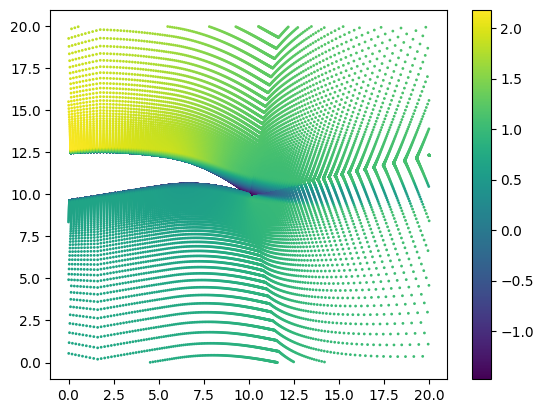

In [326]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*images_sub.detach().cpu(), s=1)
plt.colorbar()

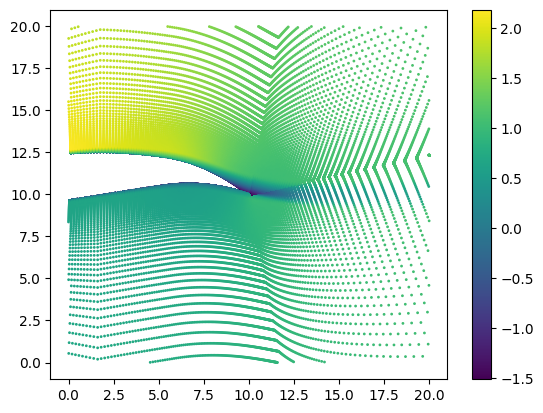

In [327]:
plt.scatter(coords_sub[..., 0].detach().cpu(), coords_sub[..., 1].detach().cpu(), c=gamma*pred.detach().cpu(), s=1)
plt.colorbar()

In [ ]:
coord_plt

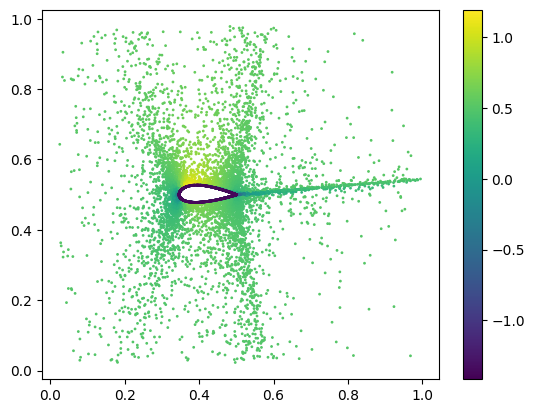

In [128]:
img_plt = images.detach().cpu()
pred_plt = pred.detach().cpu()
coord_plt = coordinates.detach().cpu()
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=img_plt, s=1)
plt.colorbar()

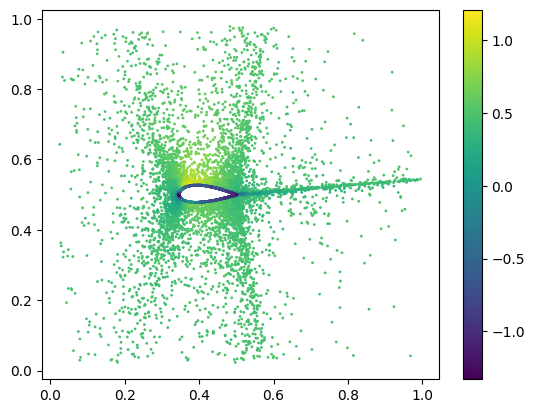

In [129]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=pred_plt*gamma, s=1)
plt.colorbar()

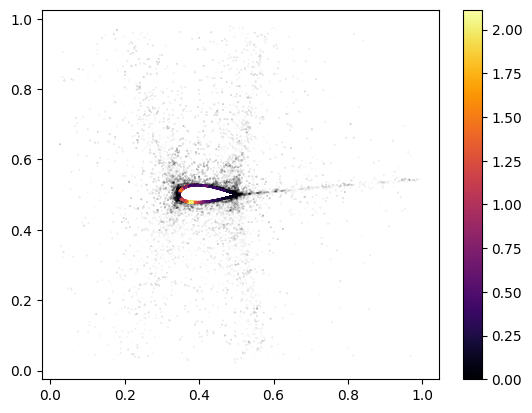

In [130]:
plt.scatter(coord_plt[..., 0], coord_plt[..., 1], c=(pred_plt*gamma-img_plt)**2, s=(pred_plt*gamma-img_plt)**2, cmap="inferno")
plt.colorbar()

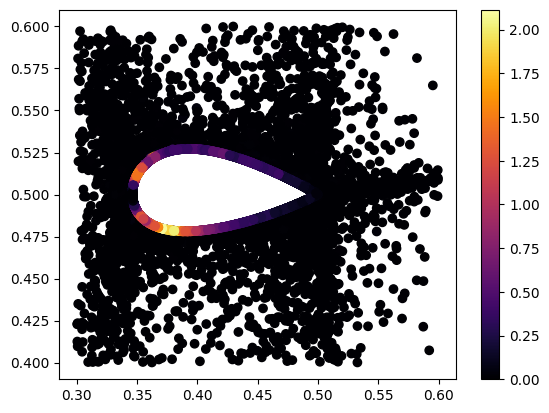

In [134]:
x_mask = (coord_plt[..., 0] < 0.6) & (coord_plt[..., 0] > 0.3)
y_mask = (coord_plt[..., 1] < 0.6) & (coord_plt[..., 1] > 0.4)
plot_mask = x_mask & y_mask
plt.scatter(coord_plt[plot_mask, 0], coord_plt[plot_mask, 1], c=((pred_plt*gamma-img_plt)**2)[plot_mask], cmap="inferno")
plt.colorbar()

In [184]:
from sklearn.cluster import KMeans

In [187]:
clustering_model = KMeans(n_clusters=128, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

In [ ]:
clustering_model.fit(gr